##**Trabalho Final de Métodos observacionais**

Disciplina: Métodos Observacionais em climatologia e Meteorologia de Mesoescala

Prof. Rosmeri Porfírio da Rocha

Novembro de 2022

Marina de Oliveira - 13712843

Tema: "ANÁLISE DE PRECIPITAÇÃO E EVAPOTRANSPIRAÇÃO NA BACIA DO PARANÁ (1980-2018) UTILIZANDO DADOS DO CRU TS V4.05"

Dados: PRE_PET_PARANA_CIC_78_20_CRU405_csv.csv

GitHub Python para Meteorologista:
https://github.com/rafaelcabreu/PythonMeteorologia2022

**SUMÁRIO**

**Estatistica básica:**
- figura série temporal
- cálculo do ciclo anual
- cálculo da anomalia
- remover tendência
- aplicação do taper

**Estatistica complexa:**
- cálculo FFT
- alisamento espectral
- graus de liberdade
- cálculo dos ruídos
- cálculo do espectro de fundo
- valores de corte, limites de confiança e bandas de 5% e 95%


# **1.Importação de bibliotecas**

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from scipy.signal import detrend
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import csv
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# **2.Funções auxiliares**

2.1 Para remover a sazonalidade
- Método de cálculo de anomalia

2.2 Para remover a tendência

2.3 Retirada de outlier

##2.1 Para remover a sazonalidade e tendência



In [ ]:
def calculate_anomaly(x, idate='1981-01-01', edate='2010-12-31'):
    return x - x.loc[idate:edate].mean()

##2.2 Para remover o outlier

In [ ]:
def outlier_remove(test):
  q1 = np.percentile(test, 25)
  q3 = np.percentile(test, 75)
  iqr = q3 - q1
  sup_limit = q3 + 1.5*iqr
  inf_limit = q1 - 1.5*iqr


  for i in range(0,test.size):
    if test[i]>sup_limit or test[i]<inf_limit:
      test[i]=(test[i-1]+test[i+1])/2
    else:
      test[i]=test[i]

  return test

#**3. Preparando para as análises**

3.1 Importar arquivo do Google Drive

3.2 Criando uma coluna DATETIME

3.3 Utilizando as funções para cálculo da sazonalidade e tendência

##3.1 Importar arquivo do Google Drive

- arquivo csv
- df é o novo dataframe
- `df.dropna()` : retira todos os NA possíveis do df

In [ ]:
drive.mount ('/content/drive')

df = pd.read_csv('drive/My Drive/Colab Notebooks/TRABALHO_METODOS/PRE_PET_PARANA_CIC_78_20_CRU405_csv.csv', sep = ';')
df_data = df.dropna()

df_data

Mounted at /content/drive


,ANO,MES,DATE,PET,PRE
0,1978.0,1.0,1/1978,133.287602,173.881003
1,1978.0,2.0,2/1978,112.851202,117.644802
2,1978.0,3.0,3/1978,113.801002,148.336203
3,1978.0,4.0,4/1978,92.280001,40.466001
4,1978.0,5.0,5/1978,73.023602,64.547601
...,...,...,...,...,...
511,2020.0,8.0,8/2020,98.921002,54.828001
512,2020.0,9.0,9/2020,116.910000,31.288201
513,2020.0,10.0,10/2020,135.525803,91.420202
514,2020.0,11.0,11/2020,144.792001,119.633202


##3.2 Criando uma coluna DATETIME

- `df_data` : é o df final bruto que será utilizado
- DATETIME lê mês e ano na mesma coluna

In [ ]:
df_data['DATE'] = pd.to_datetime(df_data['DATE'], format = 'yyyy-MM', infer_datetime_format=True)
df_data.sort_values(inplace=True, by='DATE')
df_data.head()

,ANO,MES,DATE,PET,PRE
0,1978.0,1.0,1978-01-01,133.287602,173.881003
1,1978.0,2.0,1978-02-01,112.851202,117.644802
2,1978.0,3.0,1978-03-01,113.801002,148.336203
3,1978.0,4.0,1978-04-01,92.280001,40.466001
4,1978.0,5.0,1978-05-01,73.023602,64.547601


## 3.3 Cálculo do ciclo anual

In [ ]:
df_ciclo_anualPRE = pd.DataFrame(df_data.groupby('MES').PRE.mean())
df_ciclo_anualPRE.reset_index(inplace=True)

df_ciclo_anualPET = pd.DataFrame(df_data.groupby('MES').PET.mean())
df_ciclo_anualPET.reset_index(inplace=True)

df_ciclo_anualPRE

,MES,PRE
0,1.0,189.361455
1,2.0,155.392319
2,3.0,145.982030
3,4.0,100.595685
4,5.0,76.666880
5,6.0,45.203680
6,7.0,36.971982
7,8.0,37.775810
8,9.0,67.395429
9,10.0,124.870481


In [ ]:
# transformando o DATE em index
df_data.set_index('DATE', inplace=True)

df_data.head()

,ANO,MES,PET,PRE
DATE,,,,
1978-01-01,1978.0,1.0,133.287602,173.881003
1978-02-01,1978.0,2.0,112.851202,117.644802
1978-03-01,1978.0,3.0,113.801002,148.336203
1978-04-01,1978.0,4.0,92.280001,40.466001
1978-05-01,1978.0,5.0,73.023602,64.547601


In [ ]:
# cálculo das séries aplicando a função em 2.1
df_anomaly = df_data.groupby(df_data.index.month).apply(calculate_anomaly)  # remove sazonalidade
df_detrend = sm.tsa.tsatools.detrend(df_anomaly)  # remove tendência

# 4.Plots da série temporal

## 4.1 Série temporal

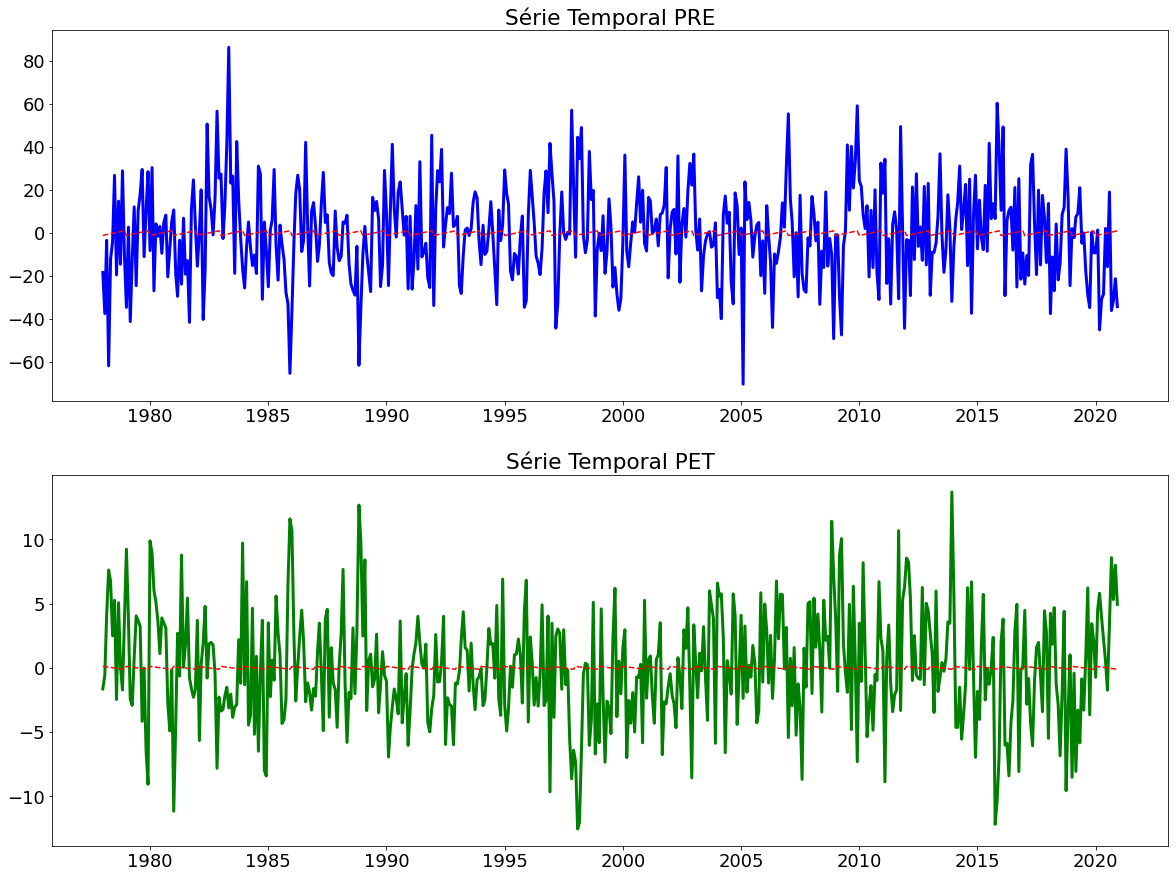

In [ ]:
font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 15)) #tamanho e dimensões da figura

# plot na posição 0 (inicial) a precipitação
# axs[0].plot(df_detrend['DATE'], df_detrend['PRE'], color='b', label= 'série temporal',lw = '3')
# axs[0].set_title('Série Temporal PRE')
axs[0].plot(df_detrend.index, df_detrend['PRE'], color='b', label= 'série temporal',lw = '3')
axs[0].set_title('Série Temporal PRE')

# plot na posição 1 (segunda) a evapotranspiração potencial
# axs[1].plot(df_detrend['DATE'], df_detrend['PET'], color='g', label= 'série temporal',lw = '3')
# axs[1].set_title('Série Temporal PET')
axs[1].plot(df_detrend.index, df_detrend['PET'], color='g', label= 'série temporal',lw = '3')
axs[1].set_title('Série Temporal PET')


X = np.array(df_detrend['ANO'].values)


z1 = np.polyfit(X, df_detrend['PRE'], 1)
z2 = np.polyfit(X, df_detrend['PET'], 1)

p1 = np.poly1d(z1)
p2 = np.poly1d(z2)

axs[0].plot(df_detrend.index, p1(X),"r--")

axs[1].plot(df_detrend.index, p2(X),"r--")


#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/SERIE_TEMPORAL_LINEAR.png', dpi=400)

plt.show()

## 4.2 Ciclo anual

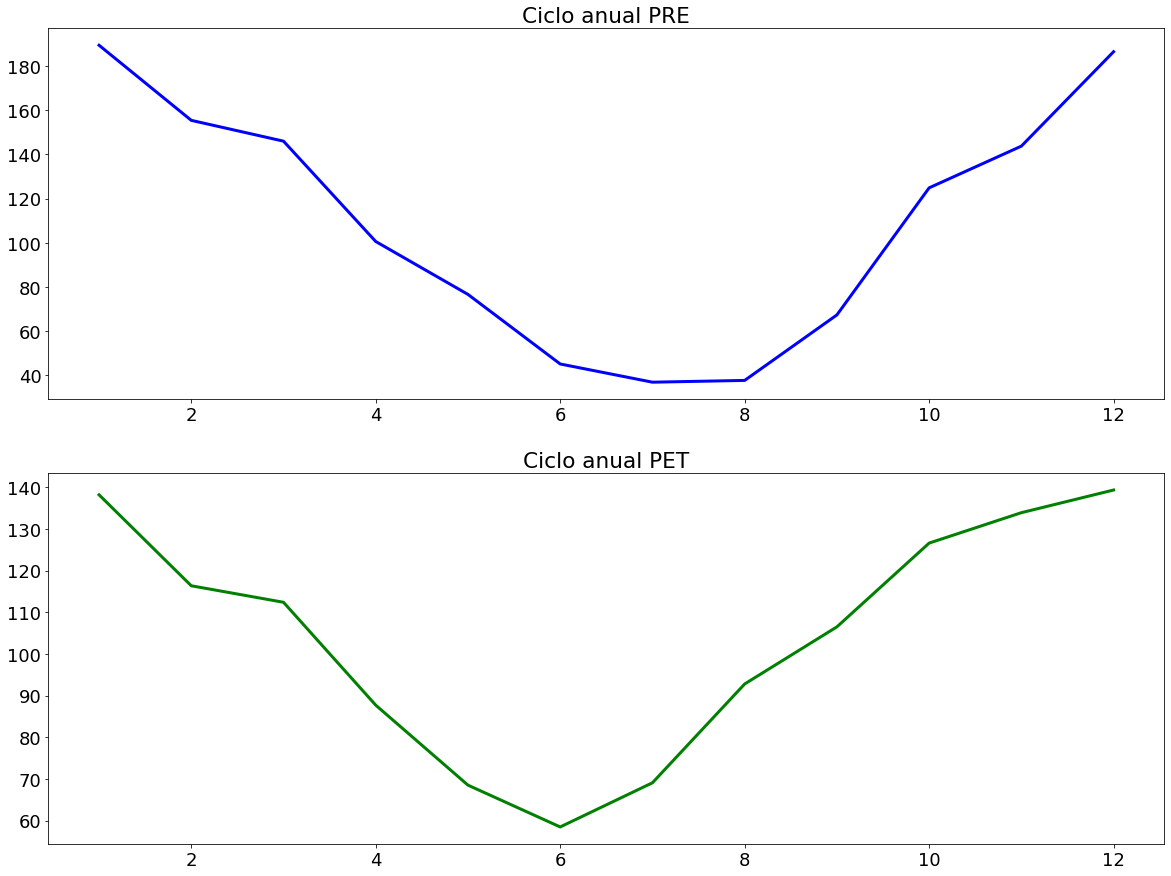

In [ ]:
font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))

axs[0].plot(df_ciclo_anualPRE['MES'], df_ciclo_anualPRE['PRE'], color='b', label= 'série temporal',lw = '3')
axs[0].set_title('Ciclo anual PRE')


axs[1].plot(df_ciclo_anualPET['MES'], df_ciclo_anualPET['PET'], color='g', label= 'série temporal',lw = '3')
axs[1].set_title('Ciclo anual PET')



#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/CICLO_ANUAL.png', dpi=400)

plt.show()

##4.3 Série de anomalia

(série temporal sem ciclo anual)

In [ ]:
# # transformando o DATE em index
# df_data.set_index('DATE', inplace=True)

# df_data.head()

In [ ]:
# cálculo das séries aplicando a função em 2.1
# df_anomaly = df_data.groupby(df_data.index.month).apply(calculate_anomaly)  # remove sazonalidade
# df_detrend = sm.tsa.tsatools.detrend(df_anomaly)  # remove tendência

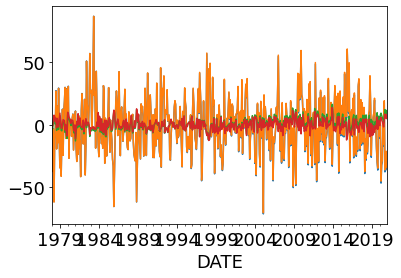

In [ ]:
# Para verificar as séries de anomalia e tendência

# precipitação
df_anomaly['PRE'].plot()
df_detrend['PRE'].plot()

# evapotranspiração
df_anomaly['PET'].plot()
df_detrend['PET'].plot()

Text(0.5, 1.0, 'Anomalia de PET')

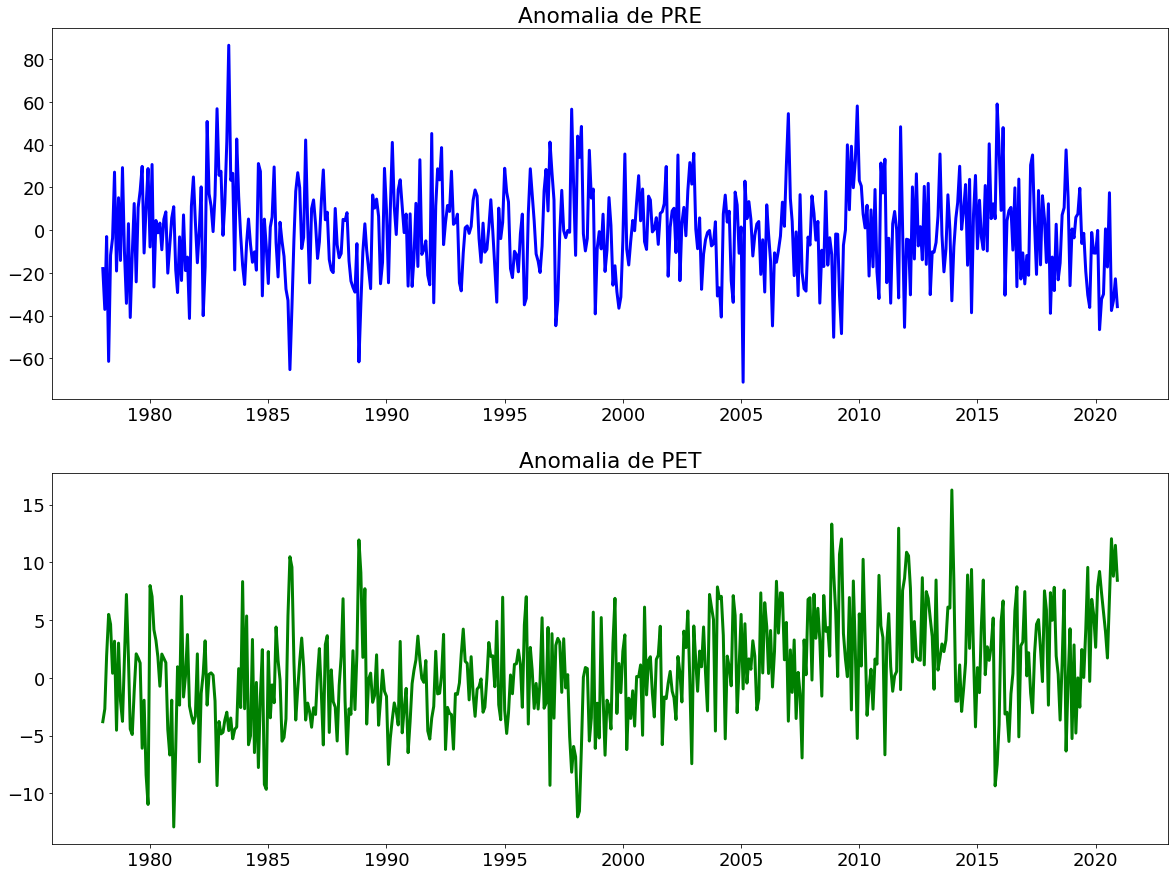

In [ ]:
# precipitação
# df_anomaly['PRE'].plot()

font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))

axs[0].plot(df_anomaly.index, df_anomaly['PRE'], color='b', lw = '3')
axs[0].set_title('Anomalia de PRE')

axs[1].plot(df_anomaly.index, df_anomaly['PET'], color='g', lw = '3')
axs[1].set_title('Anomalia de PET')


#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/SERIE_ANOMALIA.png', dpi=400)

##4.4 Série sem tendência

Text(0.5, 1.0, 'PET sem tendência')

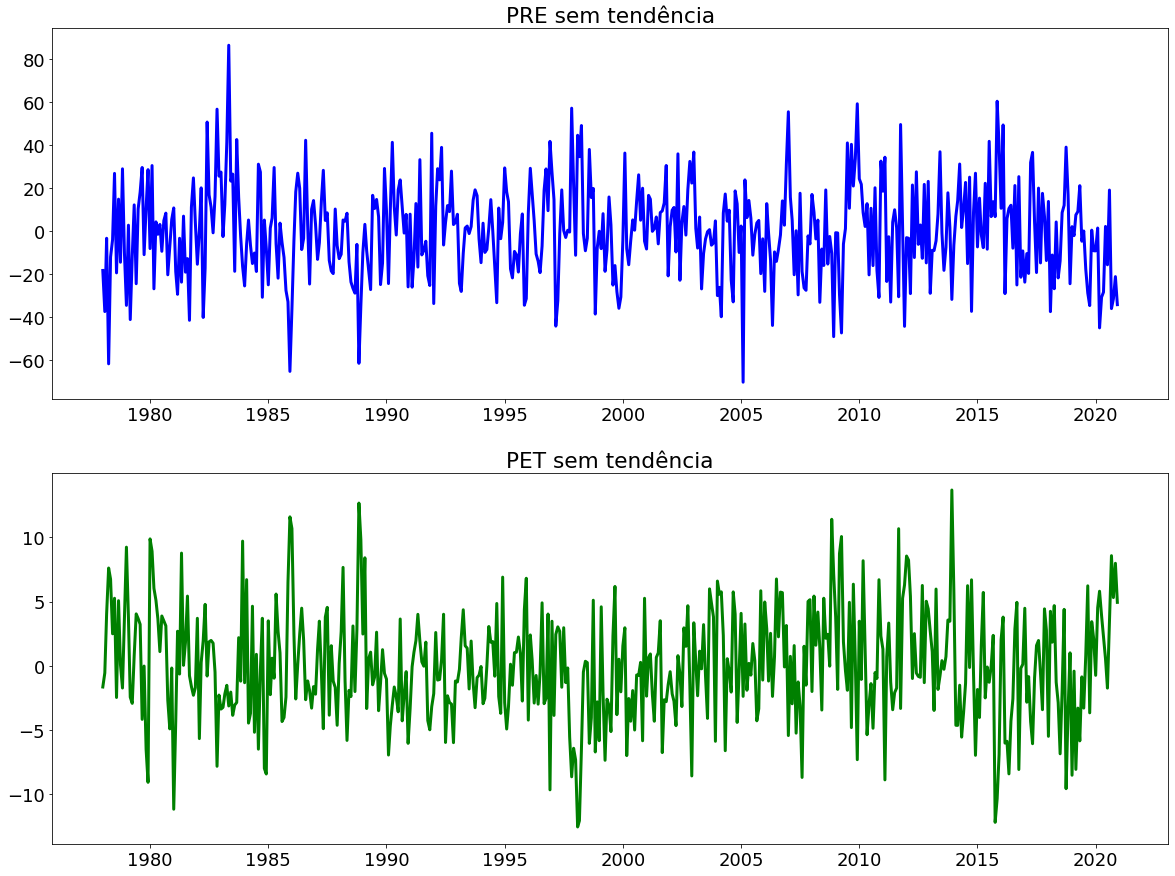

In [ ]:
font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))

axs[0].plot(df_detrend.index, df_detrend['PRE'], color='b', lw = '3')
axs[0].set_title('PRE sem tendência')

axs[1].plot(df_detrend.index, df_detrend['PET'], color='g', lw = '3')
axs[1].set_title('PET sem tendência')


#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/SERIE_SEM_TENDENCIA.png', dpi=400)

##4.5 Descição dos dados

In [ ]:
df_data["PRE"].describe()

count    516.000000
mean     109.199107
std       57.974293
min       10.547200
25%       55.202401
50%      107.526502
75%      156.425903
max      246.368605
Name: PRE, dtype: float64

In [ ]:
df_data["PET"].describe()

count    516.000000
mean     104.162319
std       27.781056
min       51.702001
25%       79.326301
50%      108.794501
75%      128.411151
max      154.690003
Name: PET, dtype: float64

# 5.Aplicação do taper

In [ ]:
tapper=10/100

## 5.1 Taper PRE

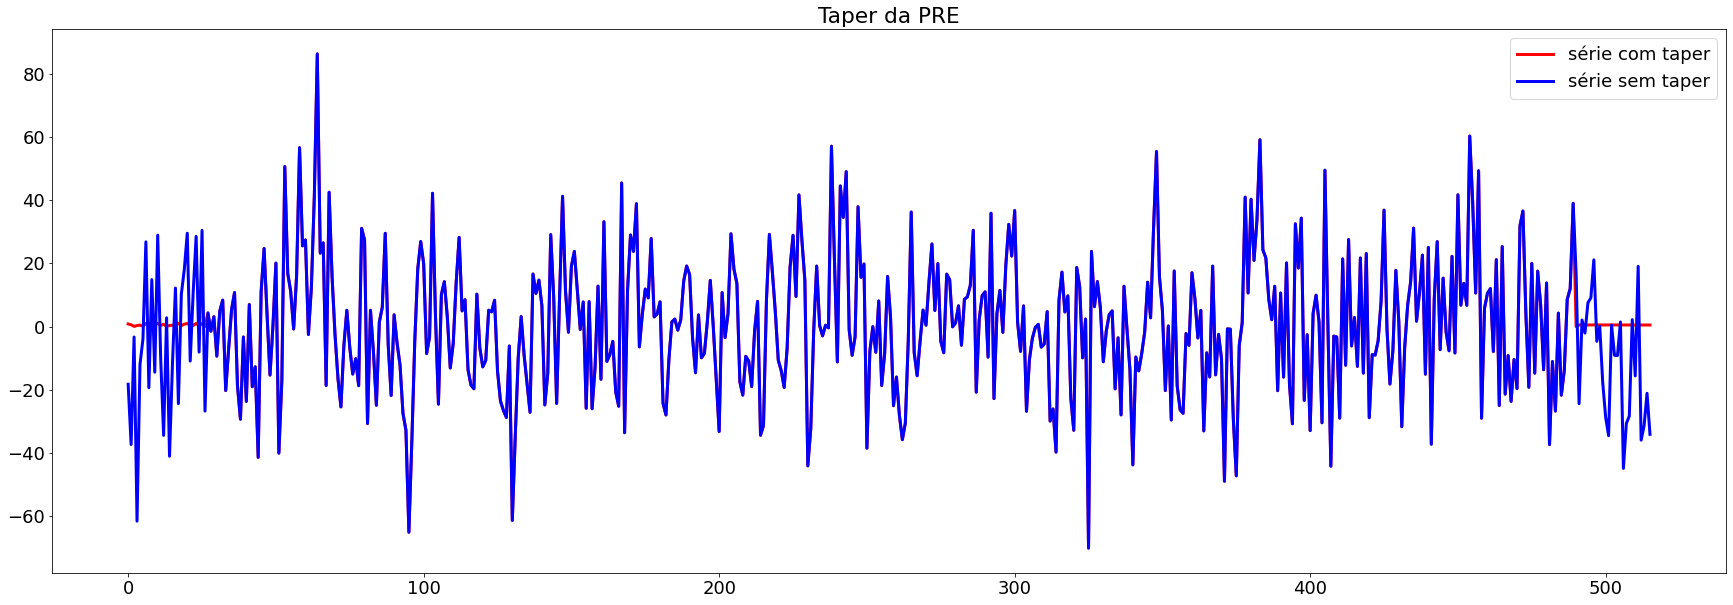

In [ ]:
ns = np.array(df_detrend['PRE']).size

m = (tapper*ns)/2
m=round(m)

w=np.zeros(ns)
for t in np.arange(0,m):
    w[t]=0.5*(1-np.cos(np.pi*(df_detrend['PRE'][t]-0.5)/m))

for t in np.arange(m+1,ns-m):
    w[t]=df_detrend['PRE'][t]

for t in np.arange((ns-m)+1,ns):
    w[t]=0.5*(1-np.cos(np.pi*(ns-df_detrend['PRE'][t])+0.5)/m)

y3=w

font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig, axs = plt.subplots( figsize=(30, 10))

axs.plot(y3,'r-', np.array(df_detrend['PRE']),'b-', lw = '3')
axs.legend(['série com taper', 'série sem taper'])
axs.set_title('Taper da PRE')

n=y3.size

spec_pre = np.fft.fft(y3)/(n)  #https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html
spec_pre = abs(spec_pre[1:(n)//2])**2   #Ck²
spec_pre = outlier_remove(spec_pre)

timestep=1
freqs_pre = np.fft.fftfreq(n, timestep)

#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/SERIE_TENDENCIA_TAPER_PRE.png', dpi=400)

In [ ]:
#spec_pre.plot()

## 5.2 Taper PET

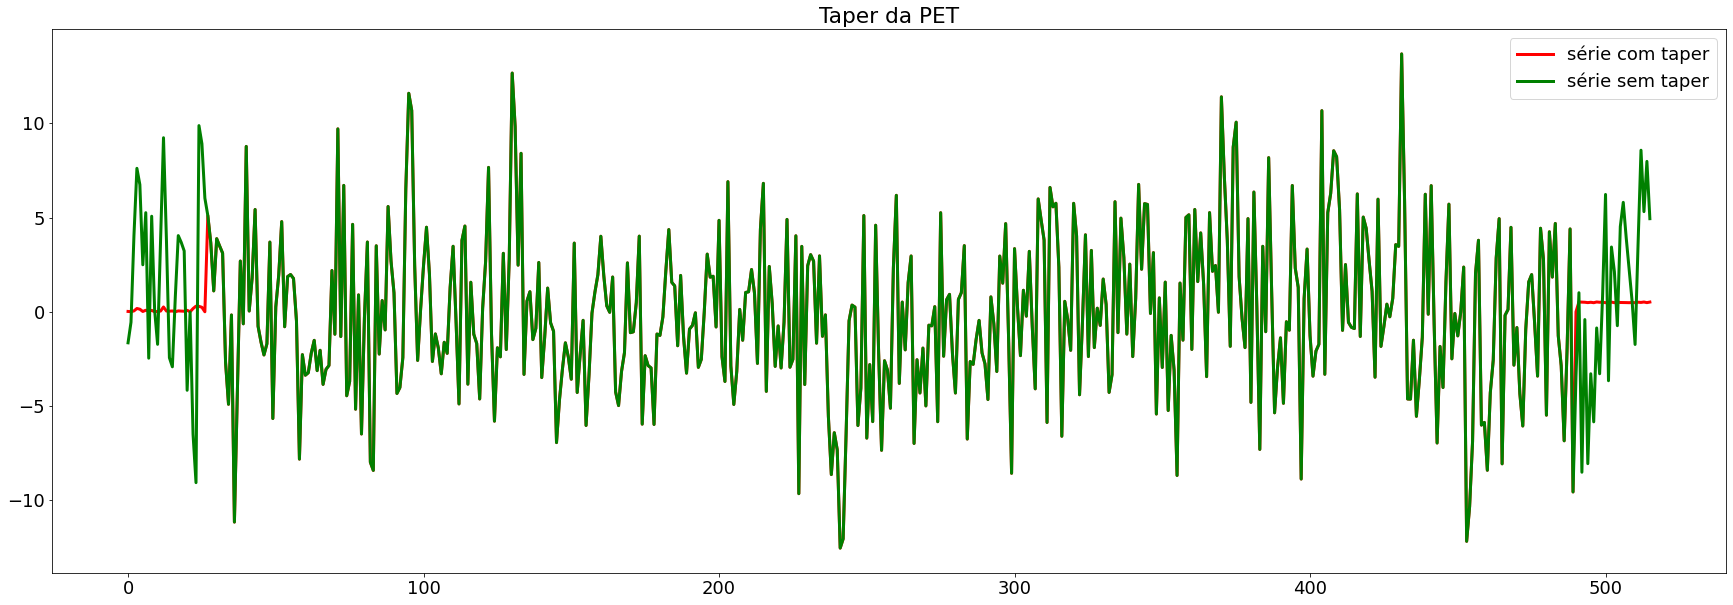

In [ ]:
ns=np.array(df_detrend['PET']).size

m=(tapper*ns)/2
m=round(m)

w=np.zeros(ns)
for t in np.arange(0,m):
    w[t]=0.5*(1-np.cos(np.pi*(df_detrend['PET'][t]-0.5)/m))

for t in np.arange(m+1,ns-m):
    w[t]=df_detrend['PET'][t]

for t in np.arange((ns-m)+1,ns):
    w[t]=0.5*(1-np.cos(np.pi*(ns-df_detrend['PET'][t])+0.5)/m)

y3=w

font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig, axs = plt.subplots( figsize=(30, 10))

axs.plot(y3,'r-', np.array(df_detrend['PET']),'g-', lw = '3')
# axs.set_xticks(df_detrend['DATE'])
axs.legend(['série com taper', 'série sem taper'])
axs.set_title('Taper da PET')

n=y3.size

spec_pet = np.fft.fft(y3)/(n)  #https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html
spec_pet = abs(spec_pet[1:(n)//2])**2   #Ck²

# spec_pet = outlier_remove(spec_pet)
for i in range(0,spec_pet.size):
  if spec_pet[i]>1:
    spec_pet[i]=spec_pet.mean()
  else:
    spec_pet[i]=spec_pet[i]

timestep=1
freqs_pet = np.fft.fftfreq(n, timestep)

#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/SERIE_TENDENCIA_TAPER_PET.png', dpi=400)

# 6.Análise espectral

## 6.1 Espectro PRE

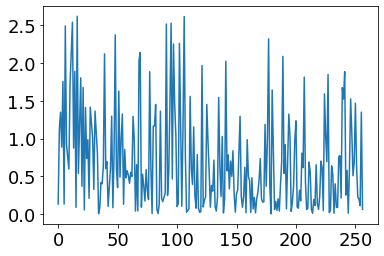

In [ ]:
# série spec_pre é a série sem o taper de 10% calculado no item anterior

plt.plot(spec_pre)

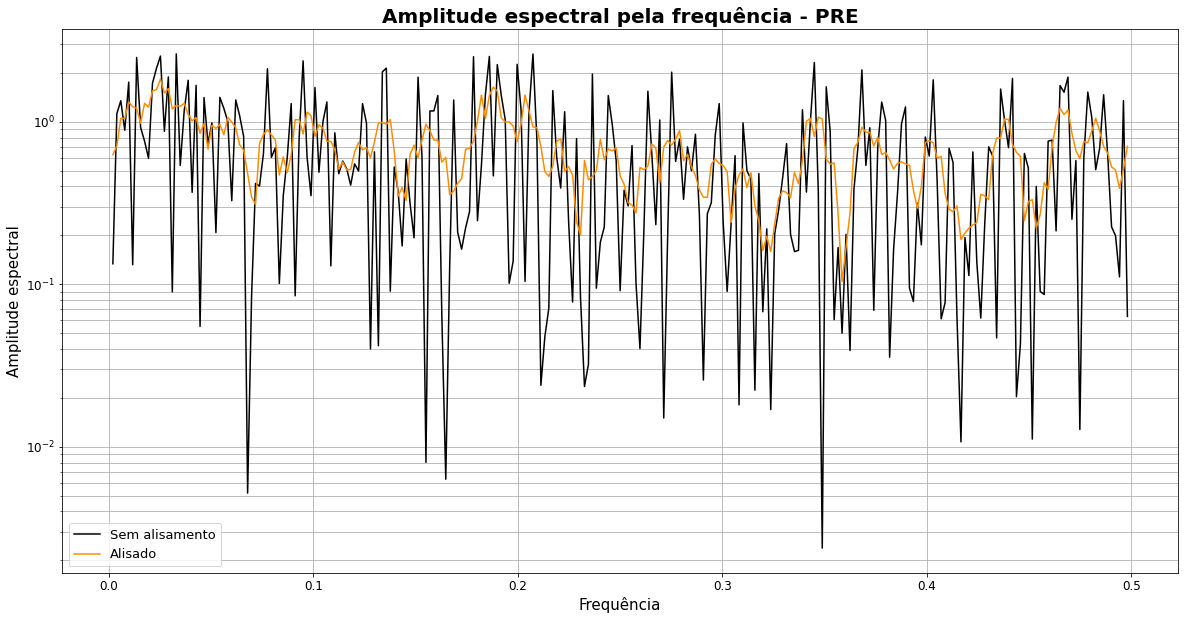

In [ ]:
spec_pre2=np.zeros(spec_pre.size)
plt.figure(figsize= (20, 10))
spec_pre2[0]=(spec_pre[0]+spec_pre[1])/2;
spec_pre2[1]=(spec_pre[0]+spec_pre[1]+spec_pre[2])/3
for i in np.arange(1,spec_pre.size-2):
  spec_pre2[i]=(spec_pre[i-2]+spec_pre[i-1]+spec_pre[i]+spec_pre[i+1]+spec_pre[i+2])/5

nn=spec_pre.size-1
spec_pre2[nn-1]=(spec_pre[nn-2]+spec_pre[nn-1]+spec_pre[nn])/3
spec_pre2[nn]=(spec_pre[nn]+spec_pre[nn-1])/2

plt.semilogy(freqs_pre[1:n//2],spec_pre, color='black')

plt.semilogy(freqs_pre[1:n//2],spec_pre2, color='darkorange')
plt.title('Amplitude espectral pela frequência - PRE', fontsize = 20, fontweight='black')
plt.xlabel("Frequência", fontsize = 15)
plt.ylabel("Amplitude espectral", fontsize = 15)
plt.tick_params(labelsize=12)
plt.legend(["Sem alisamento", "Alisado"], fontsize = 13)
plt.grid(True,which="both",ls="-")


#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/AMPLITUDE_FREQ_PRE.png', format='png', dpi=500, bbox_inches='tight')

### 6.1.2 Cálculo do lag

In [ ]:
y=df_detrend.PRE[df_detrend.index.year>=1978]
k=np.arange(1,(n-1)/2+1)
freq=k/(n-1)

### 6.1.3 Cálculo dos graus de liberdade

(Madden-Julian, 1971)

In [ ]:
N=len(y)
m=N//2


L=3 #usando a janela Daniell com 3 pontos
dof=2*L*0.873

print('Graus de liberdade: {}'.format(round(dof, 0)))

Graus de liberdade: 5.0


### 6.1.4 Cálculo da autocorrelação

(valores de R1, R2, R3)

In [ ]:
ACF=[]
for k in np.arange(0,m-1):
  ACF.append(y.autocorr(lag=k))

print('R1 = {}'.format(ACF[1]))
print('R2 = {} e R1^2 = {}'.format(ACF[2], ACF[1]**2))
print('R3 = {} e R1^3 = {}'.format(ACF[3], ACF[1]**3))

R1 = 0.21209818425783342
R2 = 0.14503167073059378 e R1^2 = 0.044985639765469855
R3 = 0.03537585704044794 e R1^3 = 0.009541372511933143


### 6.1.5 Ruído vermelho

In [ ]:
s=spec_pre2[1:m].mean()

print('Média das amplitudes: {}'.format(s))

r1 = ACF[1]
r2 = r1**2

#Thetak - ruido vermelho
RV=np.zeros(m)
for k in range(0,m):
    RV[k]=s*((1-r2)/(1+r2-2*r1*np.cos(np.pi*k/m)))
print('Ruído vermelho:"{}'.format(RV[0]))

Média das amplitudes: 0.6953623808640594
Ruído vermelho:"1.0697366885144284


### 6.1.6 Cálculo dos limites de confiança

In [ ]:
CQi=11.070  #(significância alpha=0.05)
CQs=1.145   #(significância alpha=95)


Li=RV*(CQi/dof)
Ls=RV*(CQs/dof)

# print('Limite inferior: {}'.format(Li))
# print('Limite superior: {}'.format(Ls))

### 6.1.7 Plot final: amplitude espectral ✨

largura de banda: 0.005813953488372093


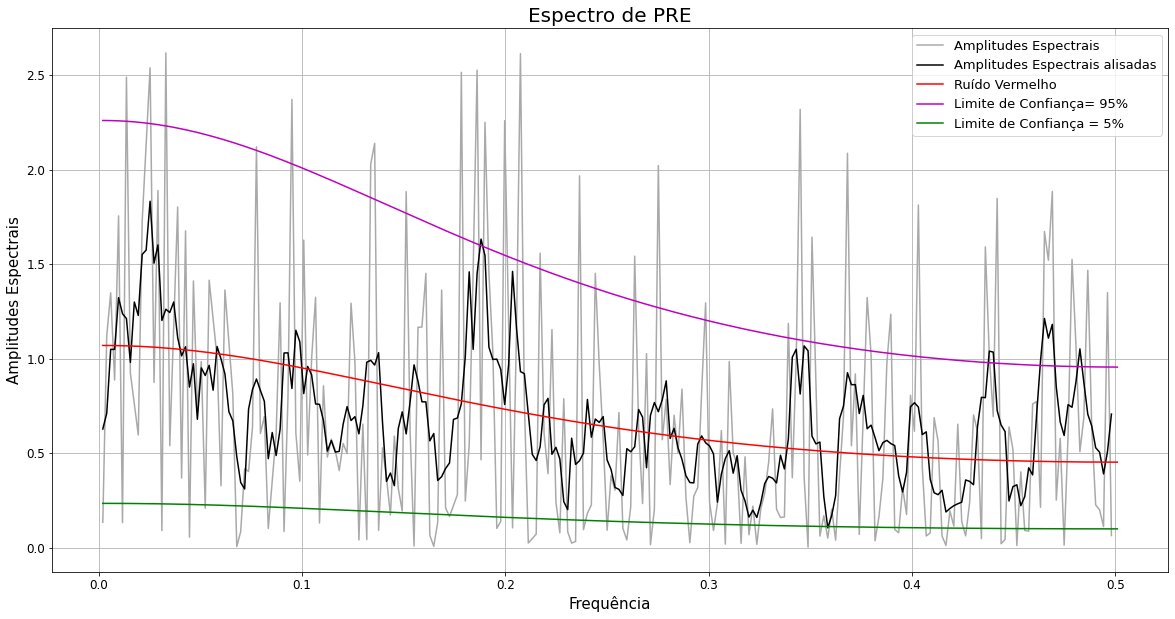

In [ ]:
plt.figure(figsize= (20, 10))

#Plot do espectro normal, alisado, ruido vermelho e níveis de confiança
plt.plot(freqs_pre[1:n//2],spec_pre, color = 'darkgray')
plt.plot(freqs_pre[1:n//2],spec_pre2, color = 'k')
#plt.axhline(y=s, color='k', linestyle='-')

plt.plot(freq,RV,'r')
plt.plot(freq,Li,'m')
plt.plot(freq,Ls,'g')
plt.grid(True,which="both",ls="-")
plt.legend(['Amplitudes Espectrais','Amplitudes Espectrais alisadas', 'Ruído Vermelho','Limite de Confiança= 95%','Limite de Confiança = 5%'], fontsize=13)
plt.xlabel('Frequência', fontsize=15)
plt.ylabel('Amplitudes Espectrais', fontsize=15)
plt.title('Espectro de PRE', fontsize=20)
plt.tick_params(labelsize=12)
plt.grid(True,which="both",ls="-")

#delimitação das bandas
bwd=(L/m)*0.5
print('largura de banda: {}'.format(bwd))

plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/ESPECTRO_PRE2.png', format='png', dpi=500, bbox_inches='tight')

## 6.2 Espectro PET

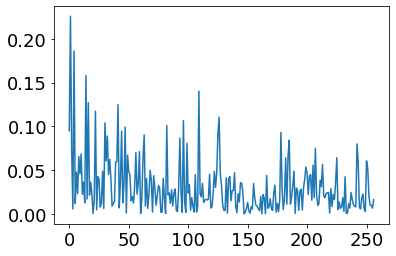

In [ ]:
# série spec_pet é a série sem o taper de 10% calculado no item 5.2
plt.plot(spec_pet)

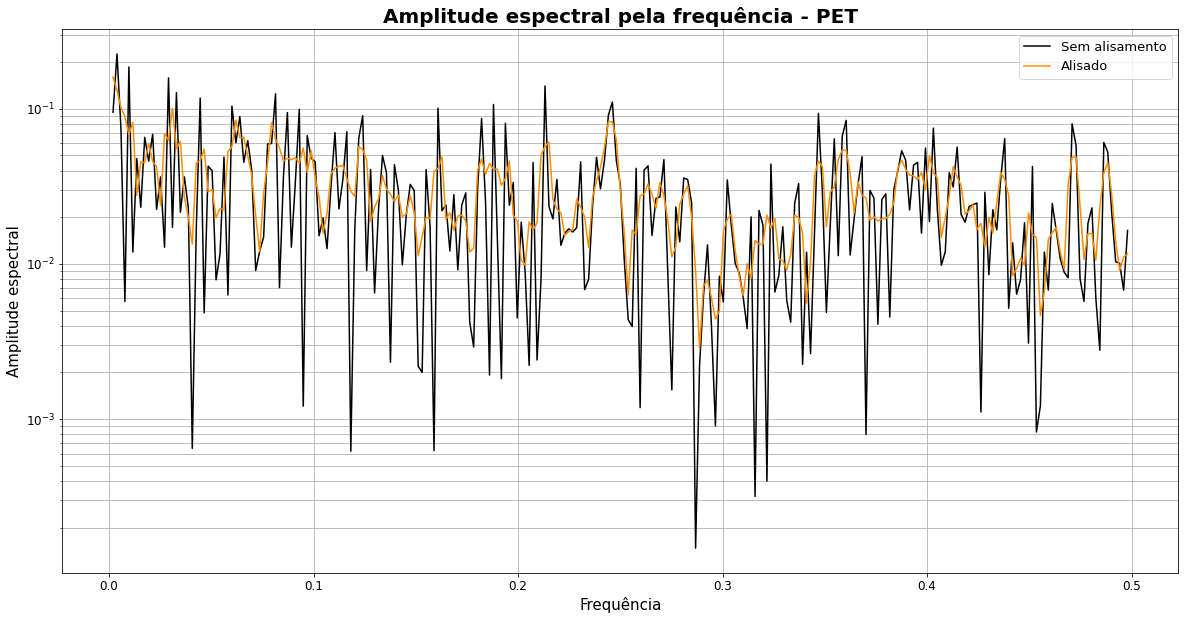

In [ ]:
spec_pet2=np.zeros(spec_pet.size)
plt.figure(figsize= (20, 10))
spec_pet2[0]=(spec_pet[0]+spec_pet[1])/2;
spec_pet2[1]=(spec_pet[0]+spec_pet[1]+spec_pet[2])/3
for i in np.arange(1,spec_pet.size-2):
  spec_pet2[i]=(spec_pet[i-1]+spec_pet[i]+spec_pet[i+1])/3

nn=spec_pet.size-1
spec_pet2[nn-1]=(spec_pet[nn-2]+spec_pet[nn-1]+spec_pet[nn])/3
spec_pet2[nn]=(spec_pet[nn]+spec_pet[nn-1])/2

plt.semilogy(freqs_pet[1:n//2],spec_pet, color='black')

plt.semilogy(freqs_pet[1:n//2],spec_pet2, color='darkorange')
plt.title('Amplitude espectral pela frequência - PET', fontsize = 20, fontweight='black')
plt.xlabel("Frequência", fontsize = 15)
plt.ylabel("Amplitude espectral", fontsize = 15)
plt.tick_params(labelsize=12)
plt.legend(["Sem alisamento", "Alisado"], fontsize = 13)
plt.grid(True,which="both",ls="-")

#plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/AMPLITUDE_FREQ_PET.png', format='png', dpi=500, bbox_inches='tight')

### 6.2.2 Cálculo do lag

In [ ]:
y=df_detrend.PET[df_detrend.index.year>=1978]
k=np.arange(1,(n-1)/2+1)
freq=k/(n-1)

### 6.2.3 Cálculo dos graus de liberdade
(Madden-Julian, 1971)

In [ ]:
N=len(y)
m=N//2


L=3 #usando a janela Daniell com 3 pontos
dof=2*L*0.873

print('Graus de liberdade: {}'.format(round(dof, 0)))

Graus de liberdade: 5.0


### 6.2.4 Cálculo da autocorrelação

In [ ]:
ACF=[]
for k in np.arange(0,m-1):
  ACF.append(y.autocorr(lag=k))

print('R1 = {}'.format(ACF[1]))
print('R2 = {} e R1^2 = {}'.format(ACF[2], ACF[1]**2))
print('R3 = {} e R1^3 = {}'.format(ACF[3], ACF[1]**3))

R1 = 0.23802521555877115
R2 = 0.14258546857542703 e R1^2 = 0.05665600324179947
R3 = 0.09020345112082064 e R1^3 = 0.013485557384327758


### 6.2.5 Ruído vermelho

In [ ]:
s=spec_pet[1:m].mean()

print('Média das amplitudes: {}'.format(s))

r1 = ACF[1]
r2=r1**2

#Thetak - ruido vermelho
RV=np.zeros(m)
for k in range(0,m):
    RV[k]=s*((1-r2)/(1+r2-2*r1*np.cos(np.pi*k/m)))
print('Ruído vermelho:{}'.format(RV[0]))

Média das amplitudes: 0.030704943416859767
Ruído vermelho:0.049888126180256384


### 6.2.6 Cálculo dos limites de confiança

In [ ]:
CQi=11.070   #(significância alpha=0.05)
CQs=1.145    #(significância alpha=95)

Li=RV*(CQi/dof)
Ls=RV*(CQs/dof)

#print('Limite inferior: {}'.format(Li))
#print('Limite superior: {}'.format(Ls))

### 6.2.7 Plot final: amplitude espectral ✨

largura de banda: 0.005813953488372093


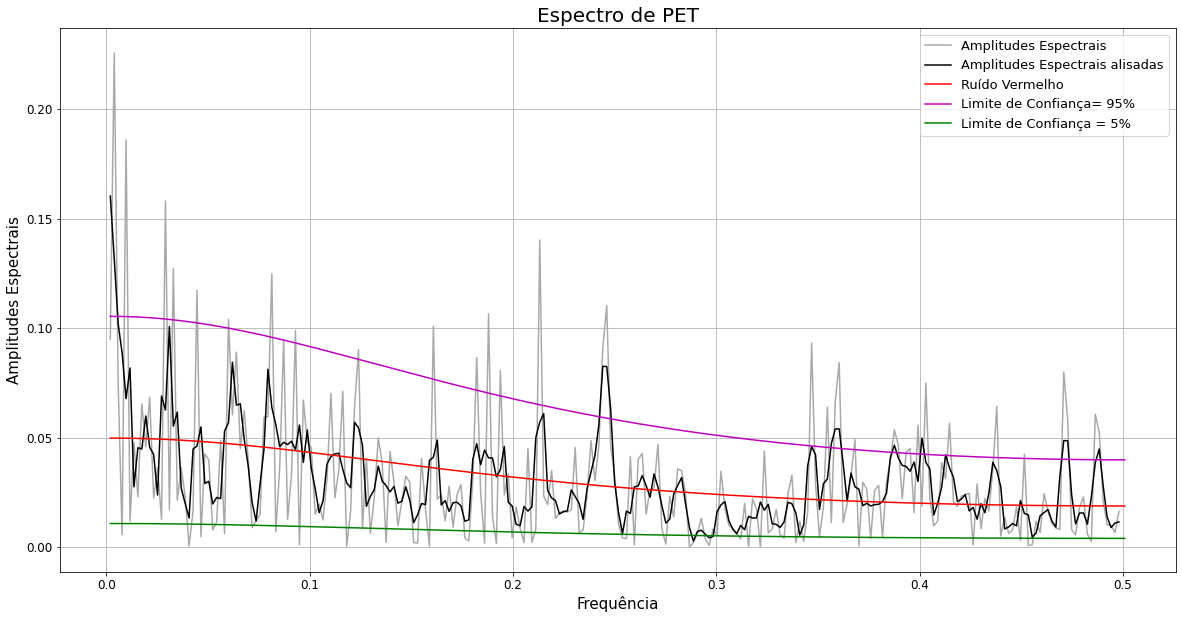

In [ ]:
plt.figure(figsize= (20, 10))

# Plot do espectro normal, alisado, ruido vermelho e níveis de confiança
plt.plot(freqs_pet[1:n//2],spec_pet, color = 'darkgray')
plt.plot(freqs_pet[1:n//2],spec_pet2, color = 'k')
#plt.axhline(y=s, color='k', linestyle='-')

plt.plot(freq,RV,'r')
plt.plot(freq,Li,'m')
plt.plot(freq,Ls,'g')
plt.grid(True,which="both",ls="-")
plt.legend(['Amplitudes Espectrais','Amplitudes Espectrais alisadas','Ruído Vermelho','Limite de Confiança= 95%','Limite de Confiança = 5%'], fontsize=13)
plt.xlabel('Frequência', fontsize=15)
plt.ylabel('Amplitudes Espectrais', fontsize=15)
plt.title('Espectro de PET', fontsize=20)
plt.tick_params(labelsize=12)
plt.grid(True,which="both",ls="-")

#delimitação das bandas
bwd=(L/m)*0.5
print('largura de banda: {}'.format(bwd))

plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/TRABALHO_METODOS/figuras/ESPECTRO_PET2.png', format='png', dpi=500, bbox_inches='tight')

In [ ]:
dfspec_pet2 = pd.DataFrame(spec_pet2)
dfspec_pet2

,0
0,0.160288
1,0.131681
2,0.101941
3,0.088695
4,0.067855
...,...
252,0.028113
253,0.013960
254,0.009077
255,0.011109
